In [1]:
# ############## AAS 237 MACHINE LEARNING WORKSHOP, JANUARY 2021 ###############
#
# TUTORIAL 1d: Visualizing neural networks
#
# GOAL: Visualize and interpret a trained convolutional neural network. 
# 
#
# DATA: We use the same dataset as in the previous tutorial 1a. These are Hubble H-band images from
# the CANDELS survey on the GOODS-S field. We provide ~3000 image cutouts of galaxies at low redshifts,
# which have been classified visually by Kartaltepe et al. (2015, https://ui.adsabs.harvard.edu/abs/2015ApJS..221...11K/abstract)
# in spheroidal and disk morphology.
# 
# 
# OUTLINE: Deep Learning is often talked about as a black box algorithm that's hard to interpret or investigate. While
# true to an extent, there are however certain techniques to open up the black box and visualize what the network has 
# 'learned'. Such visualizations can also often help perfom heuristic checks on the performance of the newtwork. In this 
# notebook we explore two such technique, (i) visualizing the clustering of activations of the second last layer of a 
# neural network (and using tSNE to embed them into 3-d), (ii) visualizing the activations of filters in the first few
# convolutional layers for a fixed test image. 
#
#
# CONTACT: Asad Khan (khan74@illinois.edu)
#
#
# ####################################################

## Data

### Load 

In [2]:
import os
"""Uncomment below two lines to force the code to run on the CPU"""
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
import time
import sys
print(sys.path)
print(sys.executable)
"""Import the basics: numpy, pandas, matplotlib, etc."""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
"""Import keras and other ML tools"""
import tensorflow as tf
import keras
print("keras version:", keras.__version__)
print("tensorflow version:", tf.__version__)
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers.core import Dropout, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
"""Import scikit learn tools"""
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
"""Import astropy libraries"""
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D

['/home/mlworkshop_usr/Tutorial_1/notebooks', '/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python37.zip', '/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python3.7', '/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python3.7/lib-dynload', '', '/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python3.7/site-packages', '/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python3.7/site-packages/IPython/extensions', '/home/mlworkshop_usr/.ipython']
/home/mlworkshop_usr/anaconda3/envs/T1P3/bin/python


Using TensorFlow backend.


keras version: 2.3.1
tensorflow version: 2.0.0-rc0


In [3]:
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)

In [4]:
"""
Load the data files. f160w_images.pickle contains the image data,
and f160w_labels.pickle contains their corresponding handles.
"""

with open('../data/f160w_images_unique.pickle', 'rb') as x:
    img_data = pickle.load(x)

with open('../data/f160w_labels_unique.pickle', 'rb') as y:
    img_labels = pickle.load(y)
    
"""Print data stats"""

print('Number of images: ', img_labels.shape[0])
print('Number of objects classified to have a disk: ', np.count_nonzero(img_labels == 1))
print('Number of objects classified as spheroid: ', np.count_nonzero(img_labels == 0))

img_data = np.expand_dims(img_data, axis=3)
img_labels = to_categorical(img_labels, num_classes=2)


Number of images:  2120
Number of objects classified to have a disk:  1693
Number of objects classified as spheroid:  427


In [5]:
"""
Use stratification to split the data into training & test samples.
This preserves the ratio of class 0 to class 1 objects when we split the
total sample into training and test samples.

"""

skf = StratifiedShuffleSplit(n_splits=2, test_size=0.15)
print(skf)
skf.get_n_splits(img_data, img_labels)


for train_index, test_index in skf.split(img_data, img_labels):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train, X_test = img_data[train_index], img_data[test_index]
    y_train, y_test = img_labels[train_index], img_labels[test_index]
    
    
"""
"""

print(np.unique(y_train))

print('Number of images in the training sample: ', X_train.shape[0])
print('Number of objects classified to have a disk in the training sample: ', np.count_nonzero(y_train == [1, 0]))
print('Number of objects classified as spheroid in the training sample: ', np.count_nonzero(y_train == [0, 1]))

print('Fraction of spheroid objects in the training sample', np.count_nonzero(y_train == [0, 1])/X_train.shape[0])

# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)


StratifiedShuffleSplit(n_splits=2, random_state=None, test_size=0.15,
            train_size=None)
[0. 1.]
Number of images in the training sample:  1802
Number of objects classified to have a disk in the training sample:  726
Number of objects classified as spheroid in the training sample:  2878
Fraction of spheroid objects in the training sample 1.5971143174250833


### Visualize 

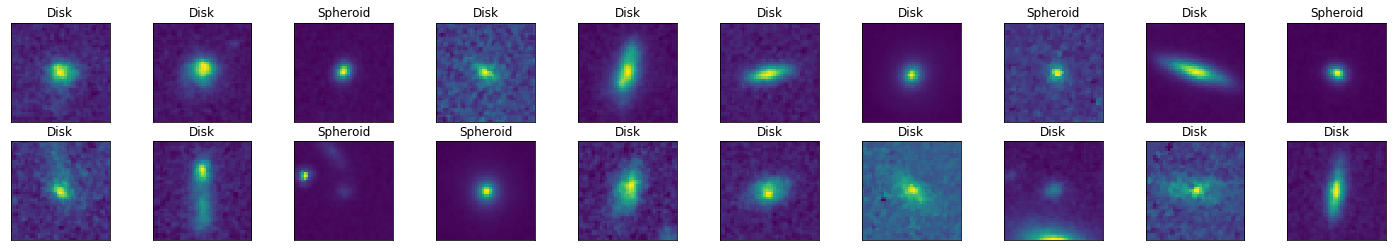

In [6]:
%matplotlib inline
    
# obtain one batch of training images
images, labels = X_train[:20], y_train[:20]


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]))
    # print out the correct label for each image
    ax.set_title(["Spheroid","Disk"][np.argmax(labels[idx])])

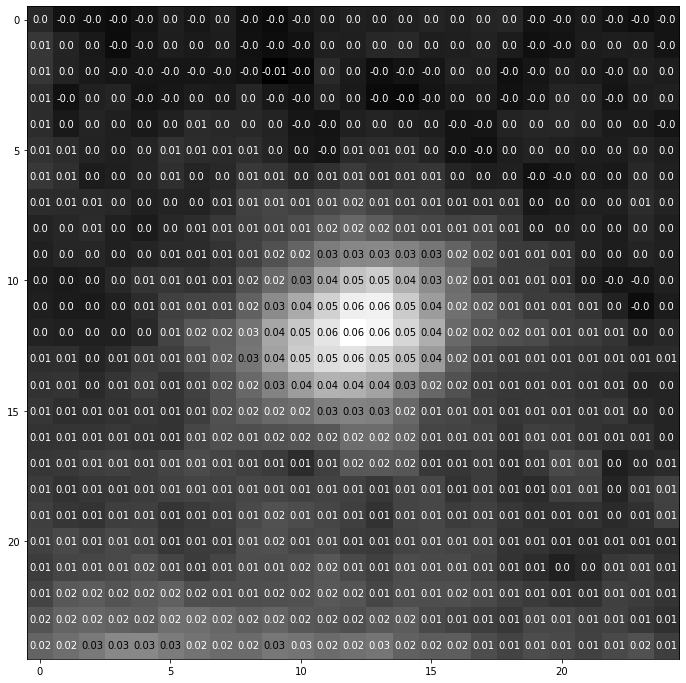

In [7]:
img = np.squeeze(images[17])[8:-8, 8:-8]

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Interpret

In [8]:
from keras.models import load_model

model = load_model('../NN_models/keras_convnet_model.h5')

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 41, 41, 16)        160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 41, 41, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        4640      
_________________________________________________________________
dropout_2 (Dropout)          (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 41, 41, 64)        18496     
_________________________________________________________________
dropout_3 (Dropout)          (None, 41, 41, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 107584)           

### Visualizing second-last-layer Activations

<img src="https://thumbs.gfycat.com/DeadlyDeafeningAtlanticblackgoby-size_restricted.gif" alt="Second Last Layer Activations" style="width: 400px;"/> (src: 3blue1brown)

In [10]:
from keras import Model

emb_model = Model(input = model.input, output = model.get_layer('dense_1').output)

/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
emb_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 41, 41, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 41, 16)        160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 41, 41, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        4640      
_________________________________________________________________
dropout_2 (Dropout)          (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 41, 41, 64)        18496     
_________________________________________________________________
dropout_3 (Dropout)          (None, 41, 41, 64)        0   

In [12]:
activations = emb_model.predict(X_test, verbose=1)
predictions = model.predict(X_test, verbose=1); labels = predictions.argmax(axis=-1)

318/318 [==============================] - 2s 5ms/step


In [13]:
activations.shape

(318, 128)

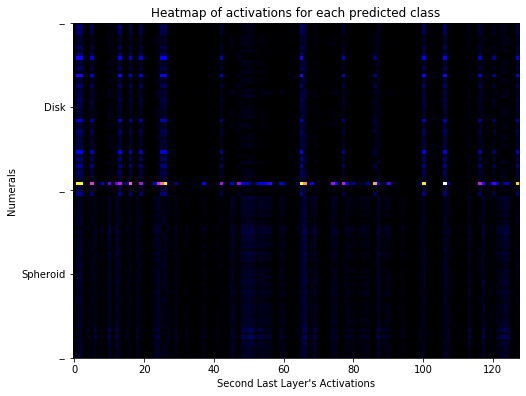

In [14]:
# Stack 10 examples of activation vectors for each numeral
seq = []
for i in range(2):
    seq.append(activations[labels==i][:50])
seq = np.vstack(seq)


# Plot heatmap for the example activations
plt.figure(figsize=(8,8))
plt.imshow(seq, interpolation='nearest', cmap=plt.cm.gnuplot2)
plt.yticks(np.arange(0,100, 24), ['--','Disk','--','Spheroid','--'])

plt.xlabel("Second Last Layer's Activations")
plt.ylabel('Numerals')
plt.title('Heatmap of activations for each predicted class')
plt.show()

#### Tensorboard

In [15]:
import io

with io.open('vecs.tsv', 'w', encoding='utf-8') as out_v:
    for embed in activations:
        out_v.write('\t'.join([str(x) for x in embed]) + "\n")
        
with io.open('meta.tsv', 'w', encoding='utf-8') as out_m:
    for l in labels:
        out_m.write(str(l) + "\n")

Now go to: https://projector.tensorflow.org/, in the data section click `Load`, and upload the two files: _vecs.tsv_ and _meta.tsv_

### Visualizing intermediate-layer activations

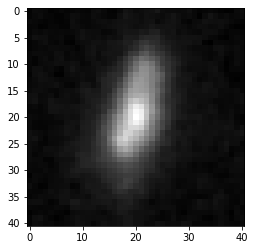

In [16]:
img = X_train[4]
img = np.expand_dims(img, axis=0)

plt.imshow(np.squeeze(img), cmap='gray')

In [17]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:6]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [18]:
# This will return a list of 8 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img)

In [19]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 41, 41, 16)


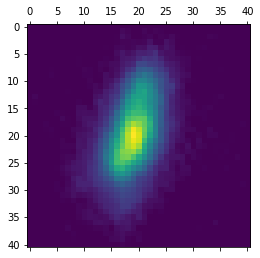

In [20]:
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
plt.show()

/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


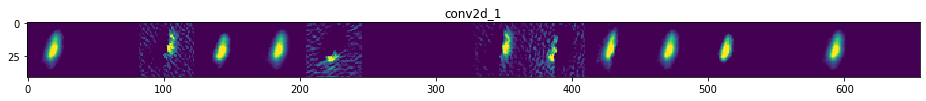

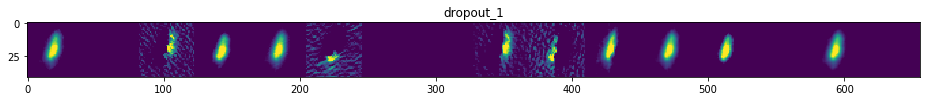

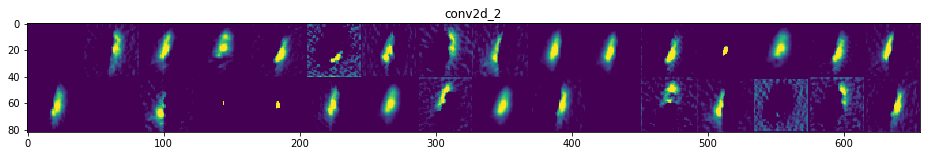

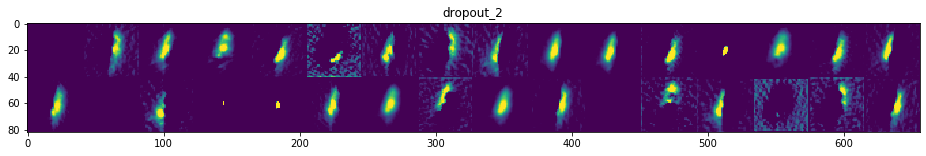

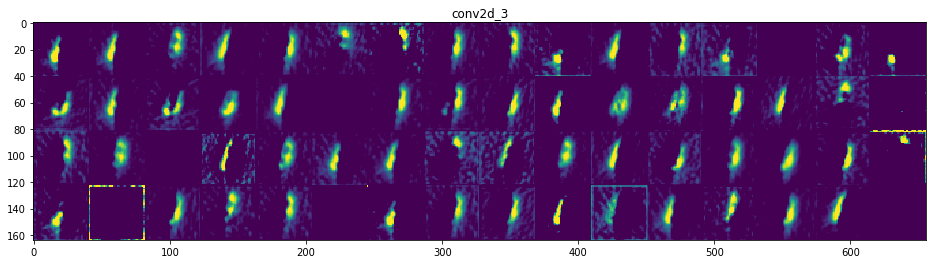

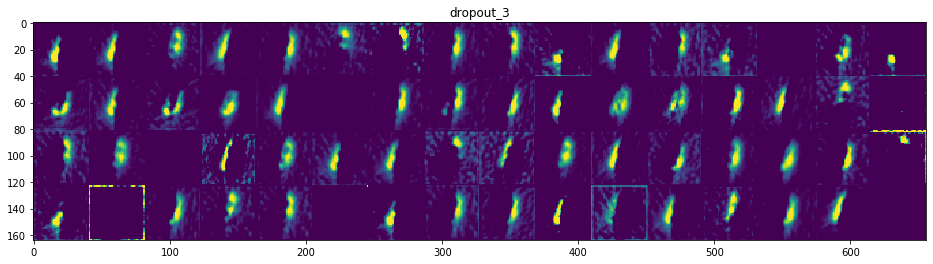

In [21]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:6]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            #channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

### References



- [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/)
- [Deep Learnig Specialization, Andrew Ng](https://www.coursera.org/specializations/deep-learning?utm_source=deeplearningai&utm_medium=institutions&utm_campaign=WebsiteCoursesDLSTopButton)
- [PyTorch Challenge, Udacity](https://www.udacity.com/facebook-pytorch-scholarship)
- [Deep Learning with Python](https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438)
- [Keras Blog](https://blog.keras.io/)